In [5]:
import tqdm
import pandas as pd
import numpy as np
from pathlib import Path
from brainprint.predictive_modelling.utils.targets import targets
from brainprint.utils.parcellations import parcellations
from brainprint.predictive_modelling.utils.data import get_data
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
atlas,labels = [parcellations.get("Brainnetome").get(key) for key in ["atlas","labels"]]
labels = pd.read_csv(labels,index_col=0)

In [96]:
target_name = "years"
parameters = ["MD","FA","AD","RD","CL","CS","CP","EigenValue","EigenVector","Thickness","Volume","Sulc"]
target = targets.get(target_name)
target = target[target < 50]
data = get_data("MD")
available_subjects = data.index.levels[0]
available_subjects = [subj for subj in available_subjects if subj in target.index]
train_indices,test_indices = train_test_split(available_subjects,test_size=0.25,random_state=42)

In [97]:
multi_columns = pd.MultiIndex.from_product([parameters,labels.index])
multi_df = pd.DataFrame(index=available_subjects,columns=multi_columns)
for param in parameters:
    param_df = get_data(param).loc[available_subjects]
    param_df.fillna(param_df.mean(),inplace=True)
    multi_df.loc[available_subjects,(param,labels.index)] = param_df.values


In [103]:
target.loc[train_indices]

,Age (years)
Subject ID,
274,32.00
247,24.00
657,19.20
249,23.00
637,18.30
...,...
631,34.00
645,29.10
252,41.00


In [98]:
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV(max_iter=1e6,l1_ratio=np.linspace(0.4,0.8,num=10),alphas=np.linspace(1,10,10),random_state=42)
# search = GridSearchCV(clf,param_grid,verbose=2)
pipe = Pipeline([("scaler",StandardScaler()),("clf",clf)])
pipe.fit(multi_df.loc[train_indices],target.loc[train_indices].values.ravel())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [94]:
pipe.score(multi_df.loc[test_indices],target.loc[test_indices].values.ravel())

0.17233721881895991

/home/groot/Projects/Predictions/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/groot/Projects/Predictions/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

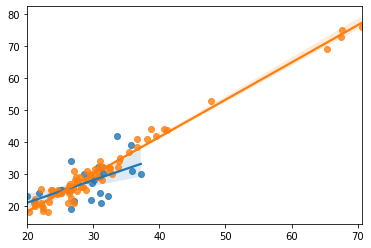

In [43]:
import seaborn as sns
preds = pipe.predict(multi_df.loc[test_indices])
sns.regplot(preds,target.loc[test_indices].values)
preds = pipe.predict(multi_df.loc[train_indices])
sns.regplot(preds,target.loc[train_indices].values)

In [49]:
feature_importances = pd.Series(pipe[1].coef_,index=multi_columns)

In [65]:
uniqes = feature_importances[feature_importances.abs()>0].index.to_frame()[1].unique()


MD    0     -0.19889
      1      0.00000
      2     -0.00000
      3      0.00000
      4     -0.00000
              ...   
Sulc  269    0.00000
      270    0.00000
      271    0.00000
      272    0.00000
      273    0.00000
Length: 3288, dtype: float64

In [71]:
feature_importances.unstack()

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,273
AD,-0.153512,0.0,-0.000000,0.000000,-0.0,-0.000000,-0.000000,0.0,-0.0,0.0,...,-0.0,-0.0,-0.000000,-0.0,0.000000,0.0,0.0,-0.000000,0.0,-0.0
CL,0.000000,-0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.025494,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
CP,0.000000,-0.0,0.000000,-0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,-0.0,0.000000,0.0,0.000000,0.0,0.0,-0.000000,0.0,0.0
CS,-0.000000,0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0
EigenValue,-0.153414,0.0,-0.000000,0.000000,-0.0,-0.000000,-0.000000,0.0,-0.0,0.0,...,-0.0,-0.0,-0.000000,-0.0,0.000000,0.0,0.0,-0.000000,0.0,-0.0
EigenVector,-0.000000,0.0,-0.235079,0.828452,0.0,0.039659,-0.000000,0.0,0.0,0.0,...,-0.0,0.0,-0.000000,-0.0,0.326652,-0.0,-0.0,0.010458,0.0,-0.0
FA,0.000000,-0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
MD,-0.198890,0.0,-0.000000,0.000000,-0.0,-0.000000,-0.000000,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.000000,-0.0,0.000000,0.0,0.0,-0.000000,0.0,-0.0
RD,-0.121426,0.0,-0.000000,0.000000,-0.0,-0.000000,-0.000000,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.000000,-0.0,0.000000,0.0,-0.0,-0.000000,0.0,-0.0
Sulc,-0.000000,-0.0,-0.000000,-0.343541,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [74]:
import nibabel as nib
img = nib.load(atlas)
data = img.get_fdata()
temp = np.zeros_like(data)
temp[temp == 0] = np.NaN
feature_importances_unstacked = feature_importances.unstack()
for i in uniqes:
    label = labels.loc[i,"Label"]
    mask = data == label
    cur_data = feature_importances_unstacked[i]
    val = cur_data[cur_data.abs() > 0].abs().mean()
    temp[mask] = val